### Mixture Density Networks - Regression Synth data Exp.I

This notebooks uses the same synthetic data as it is generated in the experiment 1, but in this case, with Mixture Density Networks (MDN)

The **hypothesis** is that MDN will be capable of modelling the uncertainty better since it makes less assumptions about the initial data distribution. Nevertheless, one of the key problems of MDN is that the output of the network increase with the number of parameters which may cause overfitting problems.

In this notebook we try to investigate if MDN are prone to overfitting as it is explained in [1]

[1] Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.


> Are Mixture Density Networks prone to overfitting?  

#### Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as K
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

import seaborn as sns

%matplotlib inline

C:\Users\yolan\Anaconda3\envs\deep_learning_keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Generate the synthetic data of the Experiment 1

In [2]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x_ = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x_*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x_ + 1 
y_ = y_1 + eps # linear data with noise

#### Describe the generated data

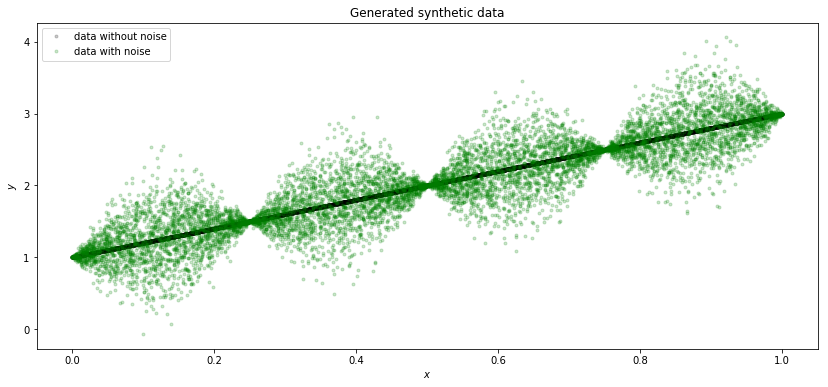

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x_, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x_, y_, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

Here, we plot the data without noise (grey line) and the noise in green.

This dataset represents a good sceneario for testing MDN since it has a simple and noise patterns with a linear function.

#### Validation and training

In [5]:
# Split into training and validation sets
n_validation = 800
x_val, x_train = x_[:n_validation].reshape(-1,1), x_[n_validation:].reshape(-1,1)
y_val, y_train = y_[:n_validation].reshape(-1,1), y_[n_validation:].reshape(-1,1)

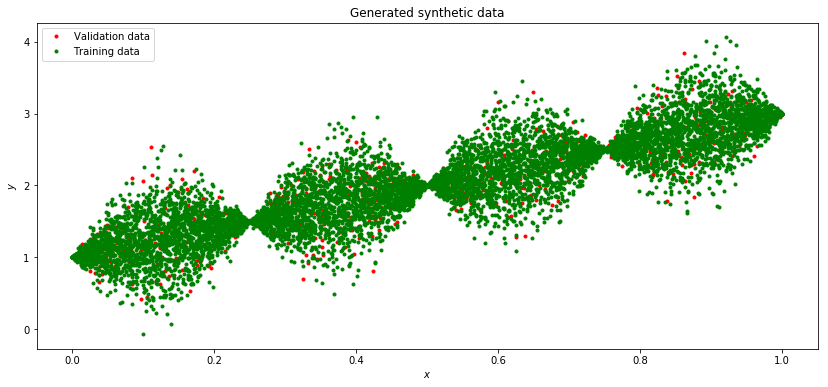

In [6]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x_val, y_val, '.', color='red' ) 
plt.plot(x_train, y_train, '.', color='green' ) 

plt.legend([r'Validation data',r'Training data', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

We take 800 points for validation purpose. The total number of datapoints in the test is 10000

### Mixture Density Network

Implementation of a MDN with Gaussian family of distribution, this model is also called GMM (Gaussian Mixture Model)

In [7]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=1000, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])
    

We use the function slice_parameter_vectors to split a compound vector with the parameters of the choosen family distribution. In this case sigma and mu

In [13]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

Here, we compute a MDN with 3 components or Gaussian Kernels. At least 2 components are necessary to be able to estimate a multimodal distribution of P(Y|X)

In [14]:
no_parameters = 3
components = 3
neurons = 200

opt = tf.optimizers.Adam(1e-3)

tf_path = os.path.join(os.getcwd(), 'tf_board')

tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
mon = EarlyStopping(monitor='val_loss', baseline=-0.1, mode='min')

In [15]:
mdn = MDN(neurons=neurons, components=components)
mdn.compile(loss=gnll_loss, optimizer=opt)

In [16]:
x_train.shape, x_val.shape

((9200, 1), (800, 1))

### Train the MDN with the synthetic generated data

We train a simple neural network with 200 neurons and 2 dense layers. The aim of this notebook is to keep the complexity of the network simple to check how easily is to overfit the network to the dataset

In [17]:
%%time
mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[tensorboard], batch_size=128, verbose=0)

Wall time: 11min 14s


### Get predictions for validation set

In [18]:
y_pred = mdn.predict(x_val)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

In [19]:
sigma_pred.shape

(800, 3)

### Plot results

We plot the prediction results. We have sigma and mu predicted for 3 different guassian kernels (red, green and yellow) 

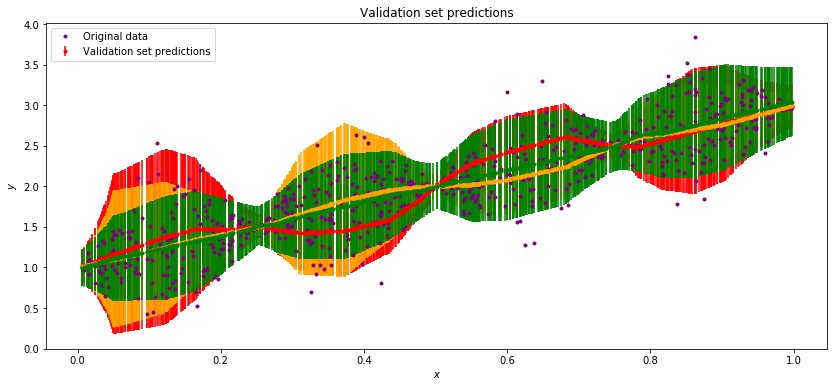

In [20]:
# Plot predictions and their errors
import numpy as np 

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val, y_val, '.', color='purple')
ax1.errorbar(x_val, mu_pred[:,0], yerr=np.sqrt(sigma_pred[:,0]) , color='red', fmt='.'); 
ax1.errorbar(x_val, mu_pred[:,1], yerr=np.sqrt(sigma_pred[:,1]) , color='orange', fmt='.'); 
ax1.errorbar(x_val, mu_pred[:,2], yerr=np.sqrt(sigma_pred[:,2]) , color='green', fmt='.'); 


# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data','Validation set predictions'], loc='upper left', );

As we can see in this plot, we have been able to predict the variance of the predictions with three gaussian kernels

Nevertheless, the network is prone to overfitting (there are predictions that clearly follow noisy patterns), the net is learning from noisy data. This cause generalization problems.
It might be solved reducing using the kernel size with only 2 gaussian kernels. 

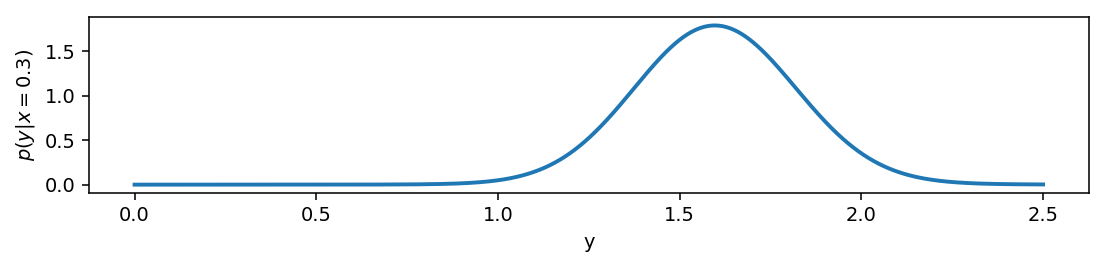

In [36]:
x_value = 0.3

alpha, mu, sigma = slice_parameter_vectors(mdn.predict([x_value]))

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))

x = np.linspace(0,2.5,int(1e4))
pyx = gm.prob(x)

fig = plt.figure(figsize=(8,2), dpi=140)
ax = plt.gca()

ax.plot(x, pyx, alpha=1, color=sns.color_palette()[0], linewidth=2)

ax.set_xlabel(r"y")
ax.set_ylabel(r"$p(y|x=" + str(x_value)+ ")$")


plt.tight_layout()

This plot represents the likelihood estimation of y for the point Xi=0.3. The sum of the three gaussian kernels

### Conclusions

* MDN are capable to adapt to multimodal distributions of P(Y|X) as opposite of the technique Exp.I 'Variance on the fly' that it is not able to accomodate this type of distribution.


* **We have validated the hypothesis that MDN are prone to overfitting**. It is not recommended its usage for a simple dataset as the one used in this notebook. 

* It can be a good solution for modelling a complex dataset. However **it has the difficulty of choosing an appropiate number of mixture components**. Finding the right number of kernels might be computational expensive. For example, in this experiment we have easily seen that 2 gaussian kernels might be enough but real datasets using multidimensional data may require a different testing strategy *(Explanation Note 1)



*Explanation Note 1*

This conclusion comes from the fact that working with too many dimensions causes every observation in your dataset to appear equidistant from all the others. This related to the Curse-of-dimensionality [1]
This might be a real problem for choosing a proper number of kernel and parameters. According to this fact, we found the following two problems:

* (1) **Normally, high multidimensional datasets requires more parameters**. MDN exponentially increase the network output with the number of parameters.
* (2) **A high number of kernels might cause the network to be very unestable**. Different observations may belong to different clusters at the same time. 

[1] https://en.wikipedia.org/wiki/Curse_of_dimensionality